In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import pandas as pd
import numpy as np
from sglm.helpers import filehelpers
from pathlib import Path

In [4]:
base_location = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs')

# load_folder = base_location / Path(r'Figure_1_2')
# h5_beta_locations = str((load_folder / Path(r'all\f1*-ft\coefs\*_best_coeffs.h5')).resolve())
# load_folder = base_location / Path(r'Figure_3')
# h5_beta_locations = str((load_folder / Path(r'all\f3*-ft\coefs\*_best_coeffs.h5')).resolve())
# load_folder = base_location / Path(r'Figure_4_g1')
# h5_beta_locations = str((load_folder / Path(r'all\f4*-ft\coefs\*_best_coeffs.h5')).resolve())
# load_folder = base_location / Path(r'Figure_4_g2')
# h5_beta_locations = str((load_folder / Path(r'all\f4*-ft\coefs\*_best_coeffs.h5')).resolve())
# load_folder = base_location / Path(r'Figure_5_g1')
# h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\coefs\*_best_coeffs.h5')).resolve())

out_folder = base_location / Path(r'final_outputs')

# h5_beta_locations = Path('/Users/josh/Dropbox (HMS)/jz/Tetanus/1194_1195_1214_1258_1259_2_best_coeffs.h5')
out_loc = str((out_folder).resolve())
h5_beta_locations = glob.glob(h5_beta_locations)

In [5]:
h5_lst = []
for h5_coef_fn in h5_beta_locations:
    h5f = pd.HDFStore(h5_coef_fn)
    h5fk = h5f.keys()
    for key in h5fk:
        h5_df = pd.read_hdf(h5f, key).reset_index()
        h5_df['fn'] = h5_coef_fn
        h5_df['key'] = key
        h5_df = h5_df.set_index(['fn','key'])
        
        
        h5_df = h5_df.sort_values('channel_name')
        h5_df['channel'] = h5_df['channel_name'].str.split('_').apply(lambda x: x[0])
        h5_df['run_num'] = h5_df['channel_name'].str.split('_').apply(lambda x: x[-1])
        
        h5_lst.append(h5_df)
concat = pd.concat(h5_lst, axis=0)

In [6]:
filehelpers.create_folder_if_not_exists(out_loc)

In [7]:
base_keys = list({
                # 'gACH':(0,0),
                # 'rDA':(0,0),
                # 'gDA':(0,0),
                'photometryCenterInIndex':(0,0),
                'photometryCenterOutIndex':(0,0),
                'photometrySideInIndex':(0,0),
                'photometrySideInIndexr':(0,0),
                'photometrySideOutIndex':(0,0),
                'sl': (0,0),
                'spnnrOff': (0,0),
                'photometryCenterInIndex':(0,0),
                'photometryCenterOutIndex':(0,0),
                'photometrySideInIndexAA':(0,0),
                'photometrySideInIndexAa':(0,0),
                'photometrySideInIndexaA':(0,0),
                'photometrySideInIndexaa':(0,0),
                'photometrySideInIndexAB':(0,0),
                'photometrySideInIndexAb':(0,0),
                'photometrySideInIndexaB':(0,0),
                'photometrySideInIndexab':(0,0),
                'photometrySideOutIndex':(0,0),
                'sl': (0,0),
                'spnnrOff': (0,0),
                }.keys())
# base_keys

In [8]:
save_mse_scatter = concat.reset_index().set_index(['mouse_id', 'channel', 'name', 'run_num'])[['mse_tr', 'mse_cv', 'mse_te']]
save_mse_scatter.to_csv(str((Path(out_loc) / f'{load_folder.parts[-1]}-mse_sctr.csv').resolve()))

save_r2_scatter = concat.reset_index().set_index(['mouse_id', 'channel', 'name', 'run_num'])[['r2_tr', 'r2_cv', 'r2_te']]
save_r2_scatter.to_csv(str((Path(out_loc) / f'{load_folder.parts[-1]}-r2_sctr.csv').resolve()))

In [9]:
agg = concat.drop(['channel_name', 'timestamp', 'run_num'], axis=1).groupby(['channel', 'name']).agg([np.size, np.mean, np.std])
stk = agg[['mse_tr', 'mse_cv', 'mse_te']].rename({'mse_tr':'01_mse_tr', 'mse_cv':'02_mse_cv', 'mse_te':'03_mse_te'}, axis=1).swaplevel(axis=1).stack()

stk['lb'] = stk['mean'] - 1.96*stk['std']/np.sqrt(stk['size'])
stk['mn'] = stk['mean']
stk['ub'] = stk['mean'] + 1.96*stk['std']/np.sqrt(stk['size'])

plt_df = stk[['lb', 'mn', 'ub']].unstack().swaplevel(axis=1)

gACH = plt_df.loc['gACH'] if 'gACH' in plt_df.reset_index()['channel'].unique() else plt_df.iloc[0:0]
rDA = plt_df.loc['rDA'] if 'rDA' in plt_df.reset_index()['channel'].unique() else plt_df.iloc[0:0]
gDA = plt_df.loc['gDA'] if 'gDA' in plt_df.reset_index()['channel'].unique() else plt_df.iloc[0:0]

save_ci = stk[['mean', 'size', 'std']].unstack().swaplevel(axis=1).sort_index(axis=1)
save_ci.to_csv(str((Path(out_loc) / f'{load_folder.parts[-1]}-mse_ci.csv').resolve()))

In [10]:
stk

mean  size       std        lb  \
channel name                                                                    
gACH    base_simple             01_mse_tr  0.748021    10  0.002902  0.746222   
                                02_mse_cv  0.748162    10  0.002825  0.746411   
                                03_mse_te  0.747385    10  0.002883  0.745599   
        base_simple_gDA_to_gACH 01_mse_tr  0.652245    10  0.002400  0.650757   
                                02_mse_cv  0.653814    10  0.002149  0.652482   
                                03_mse_te  0.652524    10  0.002339  0.651075   
        base_simple_rDA_to_gACH 01_mse_tr  0.631089    10  0.002503  0.629537   
                                02_mse_cv  0.633939    10  0.003776  0.631598   
                                03_mse_te  0.629723    10  0.002482  0.628185   
        base_words              01_mse_tr  0.743097    10  0.002800  0.741361   
                                02_mse_cv  0.745092    10  0.004401  0.742364   
                                03_mse_te  0.743137    10  0.002802  0.741400   
        base_words_gDA_to_gACH  01_mse_tr  0.636971    20  0.011098  0.632107   
                                02_mse_cv  0.639631    20  0.011131  0.634753   
                                03_mse_te  0.636992    20  0.011902  0.631776   
        gDA_to_gACH             01_mse_tr  0.903738    10  0.003303  0.901691   
                                02_mse_cv  0.903732    10  0.003582  0.901512   
                                03_mse_te  0.902194    10  0.003271  0.900166   
        rDA_to_gACH             01_mse_tr  0.852902    10  0.003375  0.850810   
                                02_mse_cv  0.853461    10  0.003567  0.851250   
                                03_mse_te  0.849702    10  0.003377  0.847609   
gDA     base_simple             01_mse_tr  0.928280    10  0.002493  0.926735   
                                02_mse_cv  0.929373    10  0.004774  0.926415   
                                03_mse_te  0.932089    10  0.002389  0.930608   
        base_simple_gACH_to_gDA 01_mse_tr  0.810431    10  0.003312  0.808379   
                                02_mse_cv  0.811409    10  0.003421  0.809288   
                                03_mse_te  0.814670    10  0.003222  0.812674   
        base_words              01_mse_tr  0.923754    10  0.002735  0.922059   
                                02_mse_cv  0.925505    10  0.004142  0.922938   
                                03_mse_te  0.928787    10  0.002659  0.927139   
        base_words_gACH_to_gDA  01_mse_tr  0.806163    10  0.003458  0.804019   
                                02_mse_cv  0.810087    10  0.005068  0.806945   
                                03_mse_te  0.811499    10  0.003358  0.809418   
        gACH_to_gDA             01_mse_tr  0.877711    10  0.002811  0.875969   
                                02_mse_cv  0.878564    10  0.005177  0.875355   
                                03_mse_te  0.881233    10  0.002753  0.879527   
rDA     base_simple             01_mse_tr  0.838589    10  0.002296  0.837166   
                                02_mse_cv  0.839907    10  0.002957  0.838074   
                                03_mse_te  0.842518    10  0.002273  0.841110   
        base_simple_gACH_to_rDA 01_mse_tr  0.733434    10  0.001722  0.732366   
                                02_mse_cv  0.734771    10  0.003280  0.732738   
                                03_mse_te  0.737637    10  0.001721  0.736570   
        base_words              01_mse_tr  0.831910    10  0.002247  0.830518   
                                02_mse_cv  0.833945    10  0.003619  0.831701   
                                03_mse_te  0.836350    10  0.002214  0.834978   
        base_words_gACH_to_rDA  01_mse_tr  0.727058    10  0.001810  0.725936   
                                02_mse_cv  0.729048    10  0.003552  0.726846   
                                03_mse_te  0.731842    10  0.001804  0.730724 

In [11]:
import matplotlib.pyplot as plt

['', '', '', '', '', '', '']


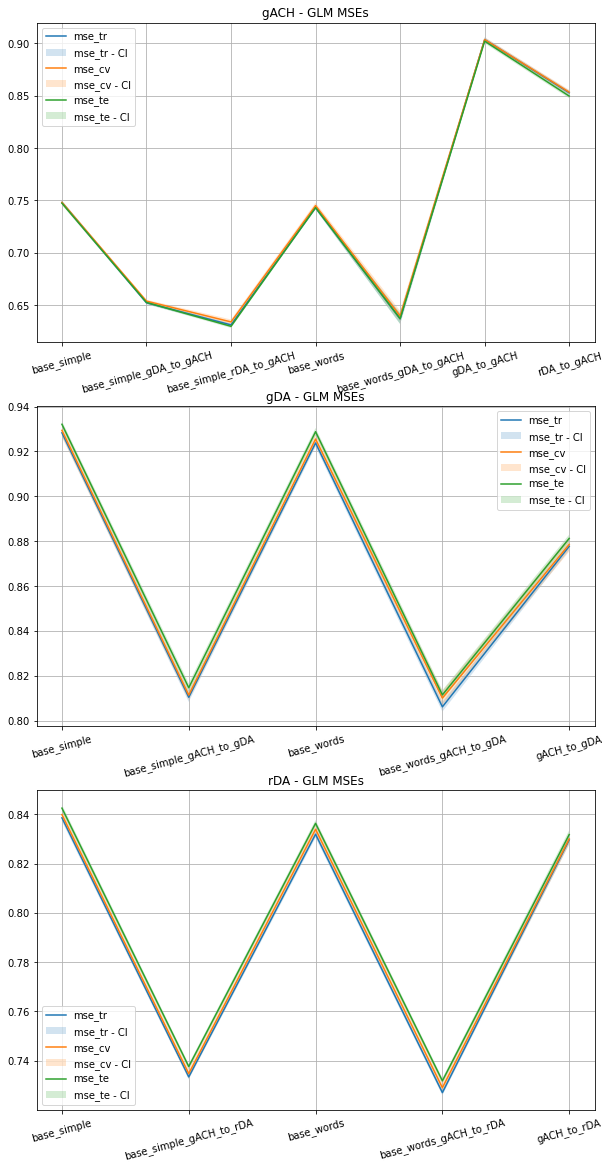

In [12]:
rot = 15

fig,axes=plt.subplots(3,1,figsize=(10,20))
fig.set_facecolor('w')

if len(gACH) > 0:
    ax = axes[0]
    ax.plot(gACH.index, gACH['01_mse_tr']['mn'], label='mse_tr')
    ax.fill_between(gACH.index, gACH['01_mse_tr']['lb'], gACH['01_mse_tr']['ub'], alpha=0.2, label='mse_tr - CI')
    ax.plot(gACH.index, gACH['02_mse_cv']['mn'], label='mse_cv')
    ax.fill_between(gACH.index, gACH['02_mse_cv']['lb'], gACH['02_mse_cv']['ub'], alpha=0.2, label='mse_cv - CI')
    ax.plot(gACH.index, gACH['03_mse_te']['mn'], label='mse_te')
    ax.fill_between(gACH.index, gACH['03_mse_te']['lb'], gACH['03_mse_te']['ub'], alpha=0.2, label='mse_te - CI')
    print([_.get_text() for _ in ax.xaxis.get_ticklabels()])
    ax.set_title('gACH - GLM MSEs')
    ax.legend()
    ax.grid(True)
    for tick in ax.get_xticklabels():
        tick.set_rotation(rot)

if len(gDA) > 0:
    ax = axes[1]
    ax.plot(gDA.index, gDA['01_mse_tr']['mn'], label='mse_tr')
    ax.fill_between(gDA.index, gDA['01_mse_tr']['lb'], gDA['01_mse_tr']['ub'], alpha=0.2, label='mse_tr - CI')
    ax.plot(gDA.index, gDA['02_mse_cv']['mn'], label='mse_cv')
    ax.fill_between(gDA.index, gDA['02_mse_cv']['lb'], gDA['02_mse_cv']['ub'], alpha=0.2, label='mse_cv - CI')
    ax.plot(gDA.index, gDA['03_mse_te']['mn'], label='mse_te')
    ax.fill_between(gDA.index, gDA['03_mse_te']['lb'], gDA['03_mse_te']['ub'], alpha=0.2, label='mse_te - CI')
    ax.set_title('gDA - GLM MSEs')
    ax.legend()
    ax.grid(True)
    for tick in ax.get_xticklabels():
        tick.set_rotation(rot)

if len(rDA) > 0:
    ax = axes[2]
    ax.plot(rDA.index, rDA['01_mse_tr']['mn'], label='mse_tr')
    ax.fill_between(rDA.index, rDA['01_mse_tr']['lb'], rDA['01_mse_tr']['ub'], alpha=0.2, label='mse_tr - CI')
    ax.plot(rDA.index, rDA['02_mse_cv']['mn'], label='mse_cv')
    ax.fill_between(rDA.index, rDA['02_mse_cv']['lb'], rDA['02_mse_cv']['ub'], alpha=0.2, label='mse_cv - CI')
    ax.plot(rDA.index, rDA['03_mse_te']['mn'], label='mse_te')
    ax.fill_between(rDA.index, rDA['03_mse_te']['lb'], rDA['03_mse_te']['ub'], alpha=0.2, label='mse_te - CI')
    ax.set_title('rDA - GLM MSEs')
    ax.legend()
    ax.grid(True)

    for tick in ax.get_xticklabels():
        tick.set_rotation(rot)

plt.show()
